In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Reading the Pima Diabetes dataset.
df = pd.read_csv('diabetes.csv')

In [14]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [15]:
# checking for what 
for col in df.columns:
    print(col, (df[col] == 0).sum())

Pregnancies 111
Glucose 5
BloodPressure 35
SkinThickness 227
Insulin 374
BMI 11
DiabetesPedigreeFunction 0
Age 0
Outcome 500


#### Choosing what to make the regressor
When we observe the counts of 0 (potential missing values), we see that glucose, BMI and Age all seem to be good candidates to pick as some sort of ground truth value we can use to predict the missing values.

One simple method is to use 3 separate regressors that perform 2d linear/polynomial regression to find the the missing values, then take the geometric mean 



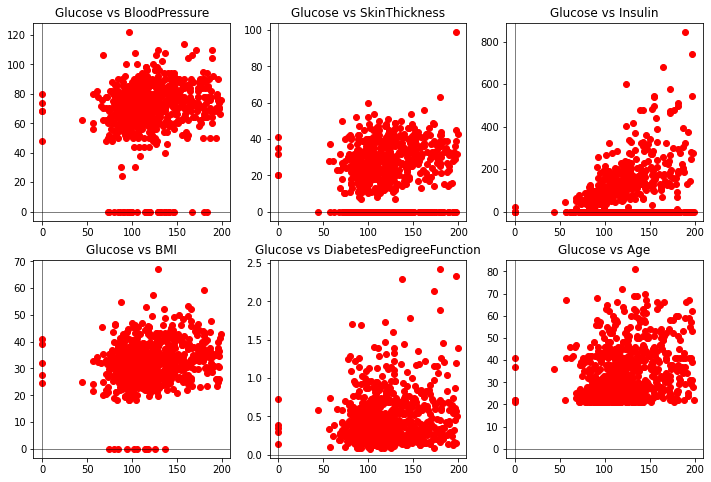

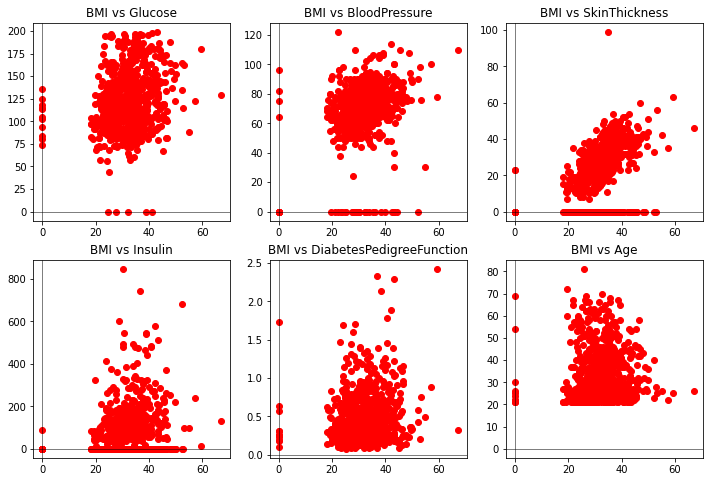

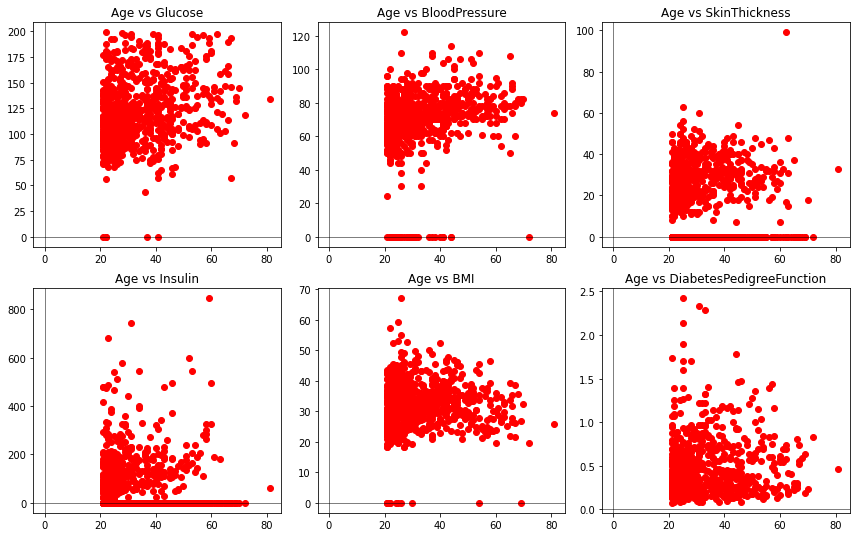

In [16]:
sel_cols = ['Glucose', 'BMI', 'Age']
for sc in sel_cols:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    i = 0
    for col in df.columns:
        if col == sc or col == 'Outcome' or col == 'Pregnancies':
            continue
        axes[i // 3][i % 3].scatter(df[sc], df[col], color='red')
        axes[i // 3][i % 3].axhline(0, color='black', linewidth=0.5)
        axes[i // 3][i % 3].axvline(0, color='black', linewidth=0.5)
        axes[i // 3][i % 3].set_title(sc + " vs " + col)
        i += 1

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [17]:
# the polynomial regression library used.
import numpy as np
import matplotlib.pyplot as plt

class BadInputError(Exception):
    def __init__(self, message="Bad input error"):
        self.message = message
        super().__init__(self.message)

class PolyFitter:
    def __init__(self, m=15):
        self._lim = m
        self._X_train = []
        self._Y_train = []
        self._X_test = []
        self._Y_test = []
        self.model = []
    
    def split_train_test(self, X, Y, train_ratio=.8):
        try:
            if (len(X) != len(Y)):
                raise BadInputError("dependent and independent variable lengths do not match")
        except BadInputError as err:
            print(err)
        
        size = int(len(X) * train_ratio)
        
        temp = np.random.choice(len(X), len(X), replace=False)
    
        indices, indices1 = temp[:size], temp[size:]
        
        # Assigning train data
        
        self._X_train = X[indices]
        self._Y_train = Y[indices]
        
        indices1 = np.array(indices1)
                
        # Assigning test data
        self._X_test = X[indices1]
        self._Y_test = Y[indices1]
    
        test_sorted_indices = np.argsort(self._X_test)
        train_sorted_indices = np.argsort(self._X_train)

        self._X_test = self._X_test[test_sorted_indices]
        self._X_train = self._X_train[train_sorted_indices]
        
        self._Y_test = self._Y_test[test_sorted_indices]
        self._Y_train = self._Y_train[train_sorted_indices]

        
        return [self._X_train, self._Y_train, self._X_test, self._Y_test]
    
    def making_A(self, m, x):
        x = np.array(x)
        data = x
        L = np.zeros((m+1,m+1))
        for i in range(2*m, m-1, -1):
            c = 0
            for j in range(i, i-m-1, -1):
                L[2 * m - i, c] = np.sum(data ** j)
                c += 1
            
        return L

    def making_B(self,m,y,x):
        y = np.array(y)
        x = np.array(x)
        data=x
        L = np.zeros((m+1,1))
        for i in range(m, -1,-1):
            L[m-i] = np.sum(y*(data**i))

        return L

    def solve_polyfit(self, A,B,m):
        coeffs = np.zeros((m,1))
        coeffs = np.linalg.solve(A,B)
        coeffs = np.flip(coeffs)
        return coeffs

    def predict_single(self, x, model= None):
        if (model == None):
            model = self.model
        predicted = 0
        for i in range(len(model)):
            predicted += model[i] * (x**i)

        return predicted

    def check(self, X, coeffs=[]):
        if len(coeffs) == 0:
            coeffs = self.model
        def PolyCoefficients(x, coeffs):
            o = len(coeffs)
            y = 0
            for i in range(o):
                y += coeffs[i][0]*x**i
            return y
        e = np.zeros(len(X))
        for i in range(len(X)):
            for j in range(len(coeffs)):
                e[i] += X[i]**j * coeffs[j][0]
                
        return PolyCoefficients(X, coeffs)

    def rmse(self, coeffs, Xt, Yt):
        e = np.zeros(len(Xt))
        for i in range(len(Xt)):
            for j in range(len(coeffs)):
                e[i] += Xt[i]**j * coeffs[j]
            
        test = Yt  
        err = test - e
        if len(err) == 0:
            raise ValueError("Error array has zero length")
        
        rmserr = np.sqrt(np.mean(err**2))
        return rmserr
    
    def make_graphs(self, X, Y, model_out, rmserr, m):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))

        model_out_sorted = model_out
        axes[0].scatter(X, Y)
        axes[0].set_title("data")
        axes[0].axhline(0, color='black', linewidth=0.5)
        axes[0].axvline(0, color='black', linewidth=0.5)

        axes[1].plot(X, model_out)
        axes[1].set_title("model output")
        axes[1].axhline(0, color='black', linewidth=0.5)
        axes[1].axvline(0, color='black', linewidth=0.5)

        axes[2].scatter(X, Y, color='green', label='data')
        axes[2].plot(X, model_out, color='blue', label='model')
        axes[2].set_title("Comparison")
        axes[2].legend()
        axes[2].axhline(0, color='black', linewidth=0.5)
        axes[2].axvline(0, color='black', linewidth=0.5)

        axes[3].scatter(model_out, abs(Y - model_out), color="red")
        axes[3].set_title("Residual")
        axes[3].axhline(0, color='black', linewidth=0.5)
        axes[3].axvline(0, color='black', linewidth=0.5)

        fig.suptitle(f'For m = {m}, rmserr = {rmserr}')

        plt.tight_layout()
        plt.show()

        
    
    def fit_model(self, X_train=[], Y_train=[], X_test=[], Y_test=[], limit=None, print_graphs=False):
        if len(X_train) == 0:
            X_train = self._X_train
        if len(Y_train) == 0:
            Y_train = self._Y_train
        if len(X_test) == 0:
            X_test = self._X_test
        if len(Y_test) == 0:
            Y_test = self._Y_test
        try:
            if len(X_train) == [] or len(Y_train) == [] or len(X_test) == 0 or len(Y_test) == 0:
                raise BadInputError("No data or insufficient data was provided to the model")
        except BadInputError as err:
            print(err)
        
        if (limit == None):
            limit = self._lim
        
        mn = None
        model = None
        for m in range(0, limit):
            coeffs = self.solve_polyfit(self.making_A(m,X_train), self.making_B(m,Y_train,X_train),m)
            model_out = self.check(X_train, coeffs)
            rmserr = self.rmse(coeffs, X_test, Y_test)

            if (mn == None):
                mn = rmserr
                model = coeffs

            if (rmserr < mn):
                mn = rmserr
                model = coeffs

            if (print_graphs):
                self.make_graphs(X_train, Y_train, model_out, rmserr, m)
                
        self.model = model
        return [mn, model, len(model)]


(135, 2)
Glucose vs BloodPressure
(126, 2)
Glucose vs SkinThickness
(117, 2)
Glucose vs Insulin
(135, 2)
Glucose vs BMI
(135, 2)
Glucose vs Age
(246, 2)
BMI vs Glucose
(246, 2)
BMI vs BloodPressure


C:\Users\sidha\AppData\Local\Temp\ipykernel_11660\3376980722.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e[i] += Xt[i]**j * coeffs[j]
C:\Users\sidha\AppData\Local\Temp\ipykernel_11660\3376980722.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e[i] += Xt[i]**j * coeffs[j]
C:\Users\sidha\AppData\Local\Temp\ipykernel_11660\3376980722.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e[i] += Xt[i]**j * coeffs[j]
C:\Users\sidha\AppData\Local\Temp\ipy

(223, 2)
BMI vs SkinThickness
(194, 2)
BMI vs Insulin
(247, 2)
BMI vs Age
(52, 2)
Age vs Glucose
(51, 2)
Age vs BloodPressure
(46, 2)
Age vs SkinThickness
(43, 2)
Age vs Insulin


C:\Users\sidha\AppData\Local\Temp\ipykernel_11660\3376980722.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e[i] += Xt[i]**j * coeffs[j]
C:\Users\sidha\AppData\Local\Temp\ipykernel_11660\3376980722.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e[i] += Xt[i]**j * coeffs[j]
C:\Users\sidha\AppData\Local\Temp\ipykernel_11660\3376980722.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e[i] += Xt[i]**j * coeffs[j]
C:\Users\sidha\AppData\Local\Temp\ipy

(52, 2)
Age vs BMI
{'Glucose vs BloodPressure': <__main__.PolyFitter object at 0x000001D8D47AC1C0>, 'Glucose vs SkinThickness': <__main__.PolyFitter object at 0x000001D8DC383C40>, 'Glucose vs Insulin': <__main__.PolyFitter object at 0x000001D8DC3A13F0>, 'Glucose vs BMI': <__main__.PolyFitter object at 0x000001D8DC3A1B10>, 'Glucose vs Age': <__main__.PolyFitter object at 0x000001D8D8726A40>, 'BMI vs Glucose': <__main__.PolyFitter object at 0x000001D8D8C095A0>, 'BMI vs BloodPressure': <__main__.PolyFitter object at 0x000001D8DC3A3070>, 'BMI vs SkinThickness': <__main__.PolyFitter object at 0x000001D8DC3A3820>, 'BMI vs Insulin': <__main__.PolyFitter object at 0x000001D8DC3A2FE0>, 'BMI vs Age': <__main__.PolyFitter object at 0x000001D8DC3A2FB0>, 'Age vs Glucose': <__main__.PolyFitter object at 0x000001D8DC3A2950>, 'Age vs BloodPressure': <__main__.PolyFitter object at 0x000001D8DC3B94E0>, 'Age vs SkinThickness': <__main__.PolyFitter object at 0x000001D8DC3B9C30>, 'Age vs Insulin': <__main_

C:\Users\sidha\AppData\Local\Temp\ipykernel_11660\3376980722.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e[i] += Xt[i]**j * coeffs[j]


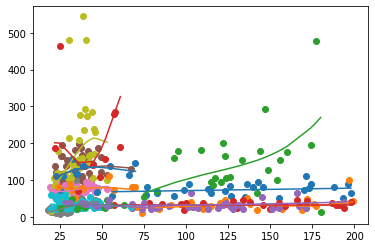

In [55]:
# finding relations between the ground truths and every other independent variable to make a model.
sel_cols = ['Glucose', 'BMI', 'Age']
mdls = {}
for sc in sel_cols:
    for col in df.columns:
        if col == sc or col == 'Outcome' or col == 'Pregnancies' or col == "DiabetesPedigreeFunction":
            continue
        model = sc + ' vs ' + col
        mdls[model] = PolyFitter()
        X = []
        y = []
        for ind, row in df.iterrows():
            if row[col] == 0 or row[sc] == 0:
                continue
            X.append(row[sc])
            y.append(row[col])
        X, y = np.array(X), np.array(y)
        data = np.column_stack((X, y))
        # Sort the data based on the independent variable (column 0)
        sorted_data = data[data[:, 0].argsort()]

        # Identify unique values of the independent variable (column 0)
        unique_values, unique_indices = np.unique(sorted_data[:, 0], return_index=True)

        # Aggregate the dependent variable values (column 1) for each unique value of the independent variable
        aggregated_data = np.array([
            [value, np.mean(sorted_data[indices, 1])]  # Example: Taking the mean of dependent variable values
            for value, indices in zip(unique_values, np.split(unique_indices, np.arange(1, len(unique_indices))))
        ])
        X, y = aggregated_data[:, 0], aggregated_data[:, 1]
        X_train, y_train, X_test, y_test = mdls[model].split_train_test(X, y)
        print(aggregated_data.shape)
        print(model)
        mdls[model].fit_model(limit = 5, X_train=X, Y_train=y, X_test=X_test, Y_test=y_test, print_graphs=False)
        plt.plot(X_test, mdls[model].check(X_test))
        plt.scatter(X_test, y_test)
        # plt.show()

print(mdls)

In [19]:
# actually imputing the missing data.
c = 1
value_to_count = 0
ground_truths = sel_cols
not_allowed = ['Outcome', 'Pregnancies', 'DiabetesPedigreeFunction']
original_df = df.copy()
from collections import Counter
for index, row in df.iterrows():
    for col in df.columns:
        # if a col is 0, then we want to predict it with the multiple models we have in our dictionary
        if row[col] == 0 and col not in not_allowed:
            amt, c = 1, 0
            for tr in ground_truths:
                # however, if one of our "ground truth" columns is zero, then exclude it from the predictors list
                if (tr == col):
                    continue

                if row[tr] != 0:
                    ss = tr + ' vs ' + col
                    amt *= mdls[ss].predict_single(row[tr])
                    c += 1
            # find all the predicted values and then find their geometric mean
            if (c > 0):
                row[col] = amt ** (1/c)


C:\Users\sidha\AppData\Local\Temp\ipykernel_11660\1367550228.py:23: RuntimeWarning: invalid value encountered in power
  row[col] = amt ** (1/c)


In [22]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# preparing the data for model fitting

data = df.copy()
y = data['Outcome']
X = data.drop(columns=['Outcome'], inplace=False)


# scale the data
scaler_X = StandardScaler()
X = scaler_X.fit_transform(np.array(X))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [49]:
from sklearn.linear_model import LogisticRegression
import numpy as np


log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

LogisticRegression()

###################### Modified data results: 


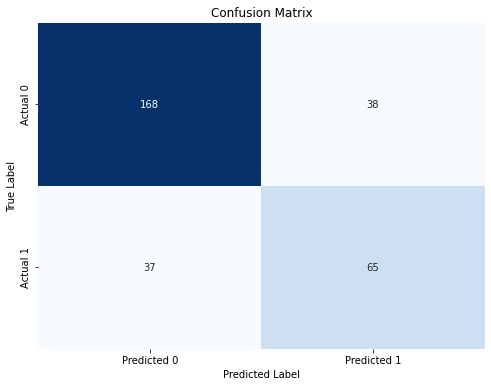

Precision: 0.6310679611650486
Recall: 0.6372549019607843
F1-score: 0.6341463414634146


In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
# checking out the results with the imputed dataset
print("###################### Modified data results: ")

y_pred = log_reg.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print or display the results
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


In [51]:
from sklearn.model_selection import train_test_split
data = original_df.copy()
#now, doing the same but without imputed data

y = data['Outcome']
X = data.drop(columns=['Outcome'], inplace=False)

scaler_X = StandardScaler()
X = scaler_X.fit_transform(np.array(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [52]:
from sklearn.linear_model import LogisticRegression
import numpy as np

log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

LogisticRegression()

###################### Modified data results: 


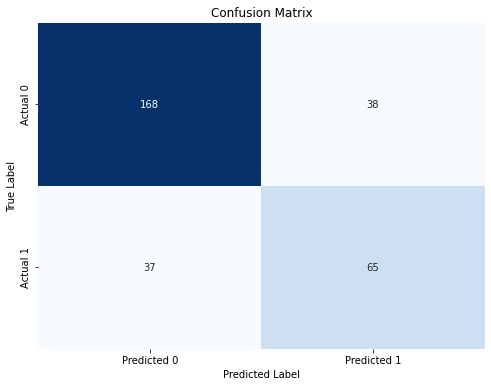

Precision: 0.6310679611650486
Recall: 0.6372549019607843
F1-score: 0.6341463414634146


In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

print("###################### Modified data results: ")

y_pred = log_reg.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print or display the results
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


As can be seen, there isn't that much of a difference in these 2 runs of the model. This implies that the approach was not effective. A more detailed study can be found in the project report.
